In [1]:
import pickle

from plot import *
from fft import *
from util import log
from maths import me, rmse, mse, mae, linear_interpolate, cosine_interpolate


In [2]:
DFT3_LEVEL_CACHE = {}


def dft3_at_level(data: np.ndarray, level: int, quantile: float = 0.75):
    if level in DFT3_LEVEL_CACHE:
        fft, amplitudes = DFT3_LEVEL_CACHE[level]
    else:
        fft = np.fft.rfftn(data)
        amplitudes = np.abs(fft)

        DFT3_LEVEL_CACHE[level] = fft, amplitudes

    fft_real = []
    fft_imag = []
    fft_i_indices = []
    fft_j_indices = []
    fft_k_indices = []

    cutoff_amp = np.quantile(amplitudes, quantile)

    for k in range(289):
        for j in range(361):
            for i in range(365 * 8):
                if amplitudes[i, j, k] < cutoff_amp:
                    continue

                fft_real.append(fft[i, j, k].real)
                fft_imag.append(fft[i, j, k].imag)
                fft_i_indices.append(i)
                fft_j_indices.append(j)
                fft_k_indices.append(k)

    fft_real = (np.array(fft_real, dtype="float32") / 262144).astype("float16")
    fft_real = encode_zlib(fft_real)

    fft_imag = (np.array(fft_imag, dtype="float32") / 262144).astype("float16")
    fft_imag = encode_zlib(fft_imag)

    fft_i_indices = np.array(fft_i_indices, dtype="int16")
    fft_i_indices = encode_difference_uint8(fft_i_indices)
    fft_i_indices = encode_zlib(fft_i_indices)

    fft_j_indices = np.array(fft_j_indices, dtype="int16")
    fft_j_indices = encode_difference_uint8(fft_j_indices)
    fft_j_indices = encode_zlib(fft_j_indices)

    fft_k_indices = np.array(fft_k_indices, dtype="int16")
    fft_k_indices = encode_difference_uint8(fft_k_indices)
    fft_k_indices = encode_zlib(fft_k_indices)

    return fft_real, fft_imag, fft_i_indices, fft_j_indices, fft_k_indices


def idft3_at_level(fft_real, fft_imag, fft_i_indices, fft_j_indices, fft_k_indices):
    ifft = np.zeros((365 * 8, 361, 289), dtype="complex64")

    fft_real = decode_zlib(fft_real, dtype="float16")
    fft_imag = decode_zlib(fft_imag, dtype="float16")
    fft = fft_real.astype("complex64") * 262144 + fft_imag.astype("complex64") * 262144j

    fft_i_indices = decode_zlib(fft_i_indices)
    fft_i_indices = decode_difference_uint8(fft_i_indices)

    fft_j_indices = decode_zlib(fft_j_indices)
    fft_j_indices = decode_difference_uint8(fft_j_indices)

    fft_k_indices = decode_zlib(fft_k_indices)
    fft_k_indices = decode_difference_uint8(fft_k_indices)

    for idx in range(len(fft)):
        ifft[fft_i_indices[idx], fft_j_indices[idx], fft_k_indices[idx]] = fft[idx]

    return np.fft.irfftn(ifft), len(fft)

In [3]:
def fit_dft3_at_level(filename: str, variable: str, level: int, verbose: bool = True, **kwargs):
    output = f"models/3D-dft/{variable}/{kwargs['quantile']}/{level}.bin"

    if os.path.exists(output):
        with open(output, "rb") as file:
            fft = pickle.load(file)
        if verbose:
            print("Loading data...")
            data = load_variable_at_level(filename, variable, level, cache=verbose)
    else:
        if verbose:
            print("Loading data...")

        data = load_variable_at_level(filename, variable, level, cache=verbose)
        if verbose:
            print("Performing DFT...")

        fft = dft3_at_level(data, level, **kwargs)
        with open(output, "wb") as file:
            pickle.dump(fft, file, protocol=pickle.HIGHEST_PROTOCOL)

    if verbose:
        data = data.astype("float32")

        print("Performing IDFT...")
        prediction, frequencies = idft3_at_level(*fft)

        size = sum(el.nbytes for el in fft)
        lines = f"""
        Original Stdev: {data.std()} m/s
        Predicted MAE:  {mae(data, prediction)} m/s
        Predicted RMSE: {rmse(data, prediction)} m/s

        Frequencies: {frequencies}
        Size/level: {size / (1000 ** 2)} MB
        Size/year: {size * 36 / (1000 ** 2)} MB
        """
        print(lines)


def fit_dft3(filename: str, variable: str, skip_levels: int = 1, **kwargs):
    levels = sorted(set(range(0, 36, skip_levels)).union({35}))
    for lev in tqdm(levels):
        fit_dft3_at_level(filename, variable, lev, verbose=False, **kwargs)
        DFT3_LEVEL_CACHE.clear()

In [85]:
fit_dft3_at_level("MERRA2.tavg3_3d_asm_Nv.YAVG{:0>2}{:0>2}.nc4", "U", quantile=0.9935, level=0)


Loading data...
Performing IDFT...

        Original Stdev: 11.381978988647461 m/s
        Predicted MAE:  0.09965647515987254 m/s
        Predicted RMSE: 0.1341450619757956 m/s

        Frequencies: 1980165
        Size/level: 7.809729 MB
        Size/year: 281.150244 MB
        


In [ ]:
fit_dft3_at_level("MERRA2.tavg3_3d_asm_Nv.YAVG{:0>2}{:0>2}.nc4", "U", quantile=0.995, level=0)

In [88]:
fit_dft3("MERRA2.tavg3_3d_asm_Nv.YAVG{:0>2}{:0>2}.nc4", "U", quantile=0.9935, skip_levels=1)


  0%|          | 0/36 [00:00<?, ?it/s]

In [ ]:
fit_dft3("MERRA2.tavg3_3d_asm_Nv.YAVG{:0>2}{:0>2}.nc4", "V", quantile=0.9935, skip_levels=1)

In [4]:
def test_fit_dft3(filename: str, variable: str, quantile: float, skip_levels: int = 1):
    data_variance = 0
    mae_error = 0
    mse_error = 0
    predicted_levels = set()
    predicted_window = []
    predicted_window_levels = []

    targets = load_variable(filename, variable, folder="raw")

    def predict_from_fft(level):
        nonlocal data_variance, mae_error, mse_error

        predicted_levels.add(level)

        with open(f"models/3D-dft/{variable}/{quantile}/{level}.bin", "rb") as file:
            fft = pickle.load(file)
        pred, _ = idft3_at_level(*fft)

        predicted_window.append(pred)
        predicted_window_levels.append(level)
        if len(predicted_window_levels) > 2:
            predicted_window.pop(0)
            predicted_window_levels.pop(0)

        data = targets[:, level].astype("float32")

        mae_loss = mae(data, pred)
        mse_loss = mse(data, pred)
        var = data.var()

        data_variance += var
        mae_error += mae_loss
        mse_error += mse_loss

        print(f"""
        Level {level}:
            Original Stdev: {var ** 0.5} m/s
            Predicted MAE:  {mae_loss} m/s
            Predicted RMSE: {mse_loss ** 0.5} m/s
        """)

    def interpolate_from_fft(level):
        nonlocal data_variance, mae_error, mse_error

        predicted_levels.add(level)

        # lev0 = max(0, lev - lev % skip_levels - 1 * skip_levels)
        lev1 = max(0, lev - lev % skip_levels)
        lev2 = min(35, lev - lev % skip_levels + skip_levels)
        # lev3 = min(35, lev - lev % skip_levels + 2 * skip_levels)
        t = (lev - lev1) / (lev2 - lev1)

        for i in (lev1, lev2):
            if i in predicted_window_levels:
                predicted_window.append(predicted_window[predicted_window_levels.index(i)])
                predicted_window_levels.append(i)

                if len(predicted_window_levels) > 2:
                    predicted_window.pop(0)
                    predicted_window_levels.pop(0)
            else:
                predict_from_fft(i)

        print(predicted_window_levels)
        data = load_variable_at_level(filename, variable, lev, cache=False).astype("float32")

        pred = linear_interpolate(predicted_window, 0, t)

        mae_loss = mae(data, pred)
        mse_loss = mse(data, pred)
        var = data.var()

        data_variance += var
        mae_error += mae_loss
        mse_error += mse_loss

        log(f"""
        Level {level}:
            Original Stdev: {var ** 0.5} m/s
            Predicted MAE:  {mae_loss} m/s
            Predicted RMSE: {mse_loss ** 0.5} m/s
        """)

    for lev in tqdm(range(36)):
        if lev in predicted_levels:
            continue

        if lev % skip_levels == 0 or lev == 35:
            predict_from_fft(lev)
            continue

        interpolate_from_fft(lev)

    lines = f"""
    Original Stdev: {(data_variance / 36) ** 0.5} m/s
    Predicted MAE:  {(mae_error / 36)} m/s
    Predicted RMSE: {(mse_error / 36) ** 0.5} m/s
    """
    log(lines)


def test_fit_dft3_skips(filename: str, variable: str, quantile: float, max_difference: int = 5):
    target = load_variable(filename, variable, folder="raw")

    predictions = []

    for level in tqdm(range(36)):
        with open(f"models/3D-dft/{variable}/{quantile}/{level}.bin", "rb") as file:
            fft = pickle.load(file)
        predictions.append(idft3_at_level(*fft)[0].astype("float16"))

    predicted_me = {}
    predicted_mae = {}
    predicted_mse = {}

    me_error = 0
    mae_error = 0
    mse_error = 0

    for level in tqdm(range(36)):
        y = target[:, level]

        me_loss = me(y, predictions[level])
        mae_loss = mae(y, predictions[level])
        mse_loss = mse(y, predictions[level])

        predicted_me[level] = me_loss
        predicted_mae[level] = mae_loss
        predicted_mse[level] = mse_loss

        mae_error += me_loss
        mae_error += mae_loss
        mse_error += mse_loss


    lines = f"""
        Predicted ME:  {(me_error / 36)} m/s
        Predicted MAE:  {(mae_error / 36)} m/s
        Predicted RMSE: {(mse_error / 36) ** 0.5} m/s
        """
    log(lines)

    with open(f"models/3D-dft/{variable}/{quantile}-predicted_me.bin", "wb") as file:
        pickle.dump(predicted_me, file)
    with open(f"models/3D-dft/{variable}/{quantile}-predicted_mae.bin", "wb") as file:
        pickle.dump(predicted_mae, file)
    with open(f"models/3D-dft/{variable}/{quantile}-predicted_mse.bin", "wb") as file:
        pickle.dump(predicted_mse, file)

    linearly_interpolated_me = {i: {} for i in range(36)}
    linearly_interpolated_mae = {i: {} for i in range(36)}
    linearly_interpolated_mse = {i: {} for i in range(36)}

    cosine_interpolated_me = {i: {} for i in range(36)}
    cosine_interpolated_mae = {i: {} for i in range(36)}
    cosine_interpolated_mse = {i: {} for i in range(36)}

    for level_u in tqdm(range(36)):
        upper = predictions[level_u]

        for level_l in tqdm(range(max(0, level_u - max_difference), level_u - 1)):
            lower = predictions[level_l]

            for level_i in range(level_l + 1, level_u):
                print(level_i, end=" ")
                t = (level_i - level_l) / (level_u - level_l)
                prediction = linear_interpolate((lower, upper), 0, t)

                y = target[:, level_i]
                linearly_interpolated_me[level_i][(level_l, level_u)] = me(y, prediction)
                linearly_interpolated_mae[level_i][(level_l, level_u)] = mae(y, prediction)
                linearly_interpolated_mse[level_i][(level_l, level_u)] = mse(y, prediction)

                if t != 0.5:
                    prediction = cosine_interpolate((lower, upper), 0, t)

                    cosine_interpolated_me[level_i][(level_l, level_u)] = me(y, prediction)
                    cosine_interpolated_mae[level_i][(level_l, level_u)] = mae(y, prediction)
                    cosine_interpolated_mse[level_i][(level_l, level_u)] = mse(y, prediction)
                else:
                    cosine_interpolated_me[level_i][(level_l, level_u)] = linearly_interpolated_me[level_i][(level_l, level_u)]
                    cosine_interpolated_mae[level_i][(level_l, level_u)] = linearly_interpolated_mae[level_i][(level_l, level_u)]
                    cosine_interpolated_mse[level_i][(level_l, level_u)] = linearly_interpolated_mse[level_i][(level_l, level_u)]

    with open(f"models/3D-dft/{variable}/{quantile}-linearly_interpolated_me.bin", "wb") as file:
        pickle.dump(linearly_interpolated_me, file)
    with open(f"models/3D-dft/{variable}/{quantile}-linearly_interpolated_mae.bin", "wb") as file:
        pickle.dump(linearly_interpolated_mae, file)
    with open(f"models/3D-dft/{variable}/{quantile}-linearly_interpolated_mse.bin", "wb") as file:
        pickle.dump(linearly_interpolated_mse, file)
    with open(f"models/3D-dft/{variable}/{quantile}-cosine_interpolated_me.bin", "wb") as file:
        pickle.dump(cosine_interpolated_me, file)
    with open(f"models/3D-dft/{variable}/{quantile}-cosine_interpolated_mae.bin", "wb") as file:
        pickle.dump(cosine_interpolated_mae, file)
    with open(f"models/3D-dft/{variable}/{quantile}-cosine_interpolated_mse.bin", "wb") as file:
        pickle.dump(cosine_interpolated_mse, file)



In [ ]:
test_fit_dft3("MERRA2.tavg3_3d_asm_Nv.YAVG{:0>2}{:0>2}.nc4", "U", quantile=0.9935)


In [5]:
test_fit_dft3_skips("MERRA2.tavg3_3d_asm_Nv.YAVG{:0>2}{:0>2}.nc4", "V", quantile=0.9935)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

[00:04:58] LOG: 
        Predicted ME:  0.0 m/s
        Predicted MAE:  0.2210316608349482 m/s
        Predicted RMSE: 0.29620106367569454 m/s
        


  0%|          | 0/36 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

1 

  0%|          | 0/2 [00:00<?, ?it/s]

1 2 2 

  0%|          | 0/3 [00:00<?, ?it/s]

1 2 3 2 3 3 

  0%|          | 0/4 [00:00<?, ?it/s]

1 2 3 4 2 3 4 3 4 4 

  0%|          | 0/4 [00:00<?, ?it/s]

2 3 4 5 3 4 5 4 5 5 

  0%|          | 0/4 [00:00<?, ?it/s]

3 4 5 6 4 5 6 5 6 6 

  0%|          | 0/4 [00:00<?, ?it/s]

4 5 6 7 5 6 7 6 7 7 

  0%|          | 0/4 [00:00<?, ?it/s]

5 6 7 8 6 7 8 7 8 8 

  0%|          | 0/4 [00:00<?, ?it/s]

6 7 8 9 7 8 9 8 9 9 

  0%|          | 0/4 [00:00<?, ?it/s]

7 8 9 10 8 9 10 9 10 10 

  0%|          | 0/4 [00:00<?, ?it/s]

8 9 10 11 9 10 11 10 11 11 

  0%|          | 0/4 [00:00<?, ?it/s]

9 10 11 12 10 11 12 11 12 12 

  0%|          | 0/4 [00:00<?, ?it/s]

10 11 12 13 11 12 13 12 13 13 

  0%|          | 0/4 [00:00<?, ?it/s]

11 12 13 14 12 13 14 13 14 14 

  0%|          | 0/4 [00:00<?, ?it/s]

12 13 14 15 13 14 15 14 15 15 

  0%|          | 0/4 [00:00<?, ?it/s]

13 14 15 16 14 15 16 15 16 16 

  0%|          | 0/4 [00:00<?, ?it/s]

14 15 16 17 15 16 17 16 17 17 

  0%|          | 0/4 [00:00<?, ?it/s]

15 16 17 18 16 17 18 17 18 18 

  0%|          | 0/4 [00:00<?, ?it/s]

16 17 18 19 17 18 19 18 19 19 

  0%|          | 0/4 [00:00<?, ?it/s]

17 18 19 20 18 19 20 19 20 20 

  0%|          | 0/4 [00:00<?, ?it/s]

18 19 20 21 19 20 21 20 21 21 

  0%|          | 0/4 [00:00<?, ?it/s]

19 20 21 22 20 21 22 21 22 22 

  0%|          | 0/4 [00:00<?, ?it/s]

20 21 22 23 21 22 23 22 23 23 

  0%|          | 0/4 [00:00<?, ?it/s]

21 22 23 24 22 23 24 23 24 24 

  0%|          | 0/4 [00:00<?, ?it/s]

22 23 24 25 23 24 25 24 25 25 

  0%|          | 0/4 [00:00<?, ?it/s]

23 24 25 26 24 25 26 25 26 26 

  0%|          | 0/4 [00:00<?, ?it/s]

24 25 26 27 25 26 27 26 27 27 

  0%|          | 0/4 [00:00<?, ?it/s]

25 26 27 28 26 27 28 27 28 28 

  0%|          | 0/4 [00:00<?, ?it/s]

26 27 28 29 27 28 29 28 29 29 

  0%|          | 0/4 [00:00<?, ?it/s]

27 28 29 30 28 29 30 29 30 30 

  0%|          | 0/4 [00:00<?, ?it/s]

28 29 30 31 29 30 31 30 31 31 

  0%|          | 0/4 [00:00<?, ?it/s]

29 30 31 32 30 31 32 31 32 32 

  0%|          | 0/4 [00:00<?, ?it/s]

30 31 32 33 31 32 33 32 33 33 

  0%|          | 0/4 [00:00<?, ?it/s]

31 32 33 34 32 33 34 33 34 34 

In [6]:
variable = "V"
quantile = 0.9935

with open(f"models/3D-dft/{variable}/{quantile}-linearly_interpolated_mae.bin", "rb") as file:
    interpolated_mae = pickle.load(file)
with open(f"models/3D-dft/{variable}/{quantile}-linearly_interpolated_mse.bin", "rb") as file:
    interpolated_mse = pickle.load(file)
with open(f"models/3D-dft/{variable}/{quantile}-predicted_mae.bin", "rb") as file:
    predicted_mae = pickle.load(file)
with open(f"models/3D-dft/{variable}/{quantile}-predicted_mse.bin", "rb") as file:
    predicted_mse = pickle.load(file)

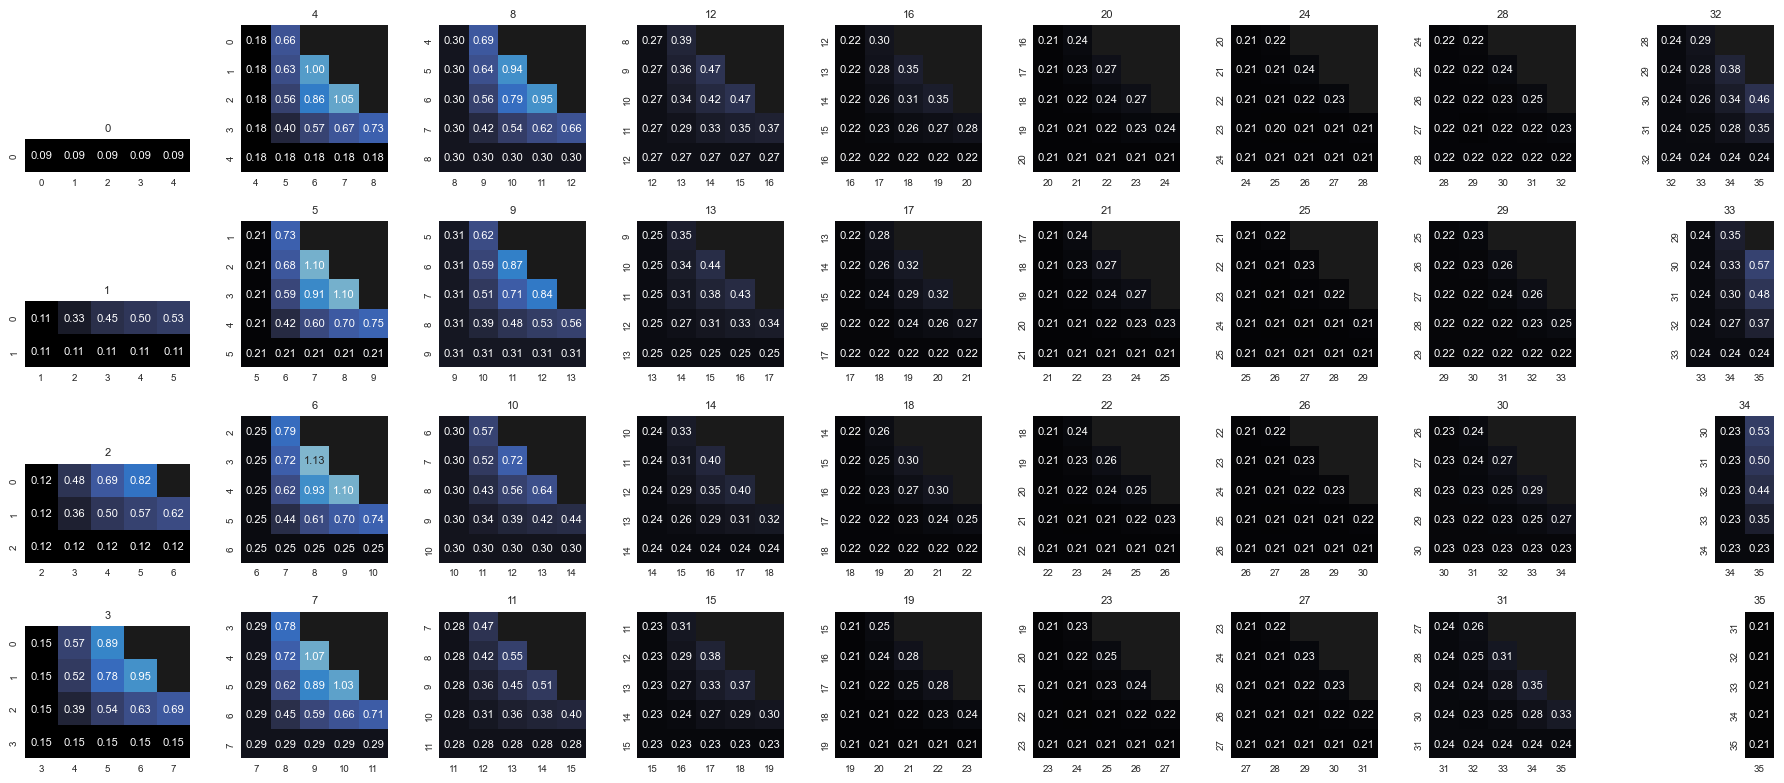

In [7]:
fig, axes = plt.subplots(4, 9, figsize=(18, 8))

for level in range(36):
    data = np.tile(np.nan, (36, 36))
    for (x, y), val in interpolated_mae[level].items():
        data[x, y] = val

    data[level, :] = predicted_mae[level]
    data[:, level] = predicted_mae[level]

    data = data[max(0, level - 4):level + 1, level:min(level + 5, 36)]

    axis = axes[level % 4][level // 4]
    axis.patch.set_facecolor((0.1, 0.1, 0.1))
    axis.grid(False)
    axis.xaxis.set_tick_params(labelsize=7, pad=-2)
    axis.yaxis.set_tick_params(labelsize=7, pad=-2)
    axis.set_anchor("SE")
    axis.set_title(level, fontdict={"fontsize": 8})

    seaborn.heatmap(data, annot=True, annot_kws={"fontsize": 8}, fmt=".2f", linewidths=0, cbar=False, square=True, vmin=0.15, vmax=1.5, ax=axis,
                    xticklabels=range(level, min(level + 5, 36)), yticklabels=range(max(0, level - 4), level + 1), cmap=cmr.arctic)

plt.tight_layout()

In [29]:
levels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 20, 23, 28, 32, 34, 35]

mae_error = 0
mse_error = 0

index = -1

for lev in range(36):
    if lev in levels:
        mae_error += predicted_mae[lev]
        mse_error += predicted_mse[lev]

        index += 1
        continue

    mae_error += interpolated_mae[lev][(levels[index], levels[index + 1])]
    mse_error += interpolated_mse[lev][(levels[index], levels[index + 1])]

lines = f"""
    Size: {100 * len(levels) / 36:.2f}%
    Predicted MAE:  {(mae_error / 36)} m/s
    Predicted RMSE: {(mse_error / 36) ** 0.5} m/s
    """
log(lines)

[09:25:36] LOG: 
    Size: 55.56%
    Predicted MAE:  0.2287665473090278 m/s
    Predicted RMSE: 0.3070688247876476 m/s
    
